<a href="https://colab.research.google.com/github/KeqingW44448/api/blob/main/RSM8421/Assignments/Assignment%20Four/RSM8421H1_Assignment_Four_Notebook_Keqing_Wang_1006927337(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
import gc # Memory Management

# Load Data

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.parquet`, `test_history.parquet`, `train_history.parquet`, and `transactions.parquet`.

In [ ]:
# This will ask you to give Colab permission to access your Google Drive
# and enter an authorization code.
# See: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# MODIFY THIS LINE with the path to where you saved the datafiles on your Google drive
path = '/content/drive/MyDrive/4.0RSM8421H1 AI and Deep Learning Tools/RSM8421_Assignment4'

In [ ]:
promos = pd.read_parquet(path + '/promos.parquet')
promos.head(50)

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935
5,73739,56844954,1,629075831,1.50,1429623935
6,97335,56844954,1,629075831,1.50,1429623935
7,37568,75228190,1,1154816776,2.00,1234009542
8,108252,75228190,1,1154816776,2.00,1234009542
9,65353,20487740,1,122801592,1.50,324788825


In [ ]:
train_history = pd.read_parquet(path + '/train_history.parquet')
train_history.head(100)

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0
...,...,...,...,...,...,...
95,186746925732,625933,37568,191747,2013-03-16,0.0
96,66295717032,150085,176321,278897,2013-03-25,0.0
97,96796340250,860548,37568,243820,2013-03-17,0.0
98,84187350295,323749,209524,42449,2013-03-01,0.0


In [ ]:
test_history = pd.read_parquet(path + '/test_history.parquet')
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [ ]:
transactions = pd.read_parquet(path + '/transactions.parquet')
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19


# Extract Features

## Compute RFM Features

In [ ]:
# ## Compute RFM Features (Optimized)
print("Computing RFM features...")
max_date = transactions.date.max()

# Aggregated transaction data
trans_features = transactions.groupby('id', as_index=False).agg({
    'date': ['nunique', 'min'],
    'amt': 'sum'
})
trans_features.columns = ['id', 'date_nunique', 'date_min', 'amt_sum']

# Compute Recency, Frequency, Monetary
trans_features['recency'] = ((max_date - trans_features['date_min']) / np.timedelta64(1, "D")).astype('float32')
trans_features['frequency'] = (trans_features['date_nunique'] /
                               ((max_date - trans_features['date_min']) / np.timedelta64(1, "D"))).astype('float32')
trans_features['monetary'] = trans_features['amt_sum'].astype('float32')

# Keep only the columns you need
trans_features = trans_features[['id', 'recency', 'frequency', 'monetary']]

# Clean up unwanted raw transaction data to free up memory
del transactions
gc.collect()

print("RFM features computed.")
trans_features.head()

Computing RFM features...
RFM features computed.


,id,recency,frequency,monetary
0,32159355,358.0,0.201117,3141.840088
1,38085541,361.0,0.146814,2231.169922
2,41697872,362.0,0.248619,5006.520020
3,54676900,358.0,0.245810,1793.020020
4,58631253,362.0,0.251381,4926.399902


In [ ]:
# ===========================================
# Ensure Promos information has been merged
# ============================================
# 1. Confirm that the promos table is loaded.
if 'promos' not in globals():
  # If it doesn't load, reload it (please confirm the path is correct).
    promos = pd.read_parquet(path + '/promos.parquet')

# 2. Check if train_history already contains 'brand'.
if 'brand' not in train_history.columns:
    print("Merge Promos information to train_history...")
    train_history = train_history.merge(promos, on='promo', how='left')
else:
    print("train_history has included brand columns，no need to merge again")

# 3. Check if test_history already contains 'brand'
if 'brand' not in test_history.columns:
    print("Merge Promos information to test_history...")
    test_history = test_history.merge(promos, on='promo', how='left')
else:
    print("test_history has included brand column，no need to merge again")

# 4. Final Confirmation
print("\n the current train_history column names:", train_history.columns.tolist())

# If the printed column names contain 'brand', 'category', etc.
# You can now safely run the Target Encoding code below.

Merge Promos information to train_history...
Merge Promos information to test_history...

 the current train_history column names: ['id', 'store', 'promo', 'region', 'promodate', 'active', 'category', 'promoqty', 'manufacturer', 'promoval', 'brand']


In [ ]:
# ## Target Encoding (The Key to High AUC)

def kfold_target_encoding(train_df, test_df, target_col, cat_cols, n_splits=5): #Target Columns are columns already been merged on the training set historical columns
    """
    Use K-Fold target encoding to prevent overfitting.
    """
    print("Starting Target Encoding...")
    # Copy data
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = train_df[target_col].mean()

    encoded_cols = []

    for col in cat_cols:
        new_col = col + '_target_enc'
        encoded_cols.append(new_col)

      # Initialize new column
        train_encoded[new_col] = np.nan

    # 1. Training set (Out-of-Fold encoding) - Preventing data leakage
        for train_index, val_index in kfold.split(train_df):
            X_train, X_val = train_df.iloc[train_index], train_df.iloc[val_index]
            means = X_train.groupby(col)[target_col].mean()
            train_encoded.loc[val_index, new_col] = X_val[col].map(means) ##?? What is this step

       # Fill in missing values ​​in the training set (using the global mean)
        train_encoded[new_col] = train_encoded[new_col].fillna(global_mean)

       # 2. Test set (encoded using the full training set)
        means_full = train_df.groupby(col)[target_col].mean() ##?
        test_encoded[new_col] = test_df[col].map(means_full) ##??
        test_encoded[new_col] = test_encoded[new_col].fillna(global_mean) ##?

    print(f"Target Encoding done. New features: {encoded_cols}")
    return train_encoded, test_encoded, encoded_cols

# Specify the column to be encoded
cat_cols = ['store', 'brand', 'category', 'manufacturer', 'region']

# Execution Coding
train_encoded, predict_encoded, test_features = kfold_target_encoding(
    train_history, test_history,
    target_col='active',
    cat_cols=cat_cols
)

Starting Target Encoding...
Target Encoding done. New features: ['store_target_enc', 'brand_target_enc', 'category_target_enc', 'manufacturer_target_enc', 'region_target_enc']


## Generate train, test and prediction sets

In [ ]:
# ## Generate train, test and prediction sets

print("Merging all features...")

# 1. Merging RFM features
train_final = train_encoded.merge(trans_features, on='id', how='left')
predict_final = predict_encoded.merge(trans_features, on='id', how='left')

# 2. Add a simple promo_count feature
promo_counts = train_history.groupby('id', as_index=False)['promo'].count()
promo_counts.columns = ['id', 'promo_count']
train_final = train_final.merge(promo_counts, on='id', how='left')
predict_final = predict_final.merge(promo_counts, on='id', how='left')

# 3. Fill in missing values
fill_values = {
    'recency': 365,
    'frequency': 0,
    'monetary': 0,
    'promo_count': 0
}
train_final.fillna(value=fill_values, inplace=True)
predict_final.fillna(value=fill_values, inplace=True)

# 4. Define the final feature list (RFM + Target Encoded + Promo Count)
feature_cols = ['recency', 'frequency', 'monetary', 'promo_count'] + test_features

print("Final feature list:", feature_cols)

# Prepare training data
X = train_final[feature_cols]
y = train_final['active']

# Split the training and validation sets (for viewing AUC)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

Merging all features...
Final feature list: ['recency', 'frequency', 'monetary', 'promo_count', 'store_target_enc', 'brand_target_enc', 'category_target_enc', 'manufacturer_target_enc', 'region_target_enc']


# Build Model

Training Optimized Random Forest...
Test Accuracy: 0.6830
Test AUC: 0.6877


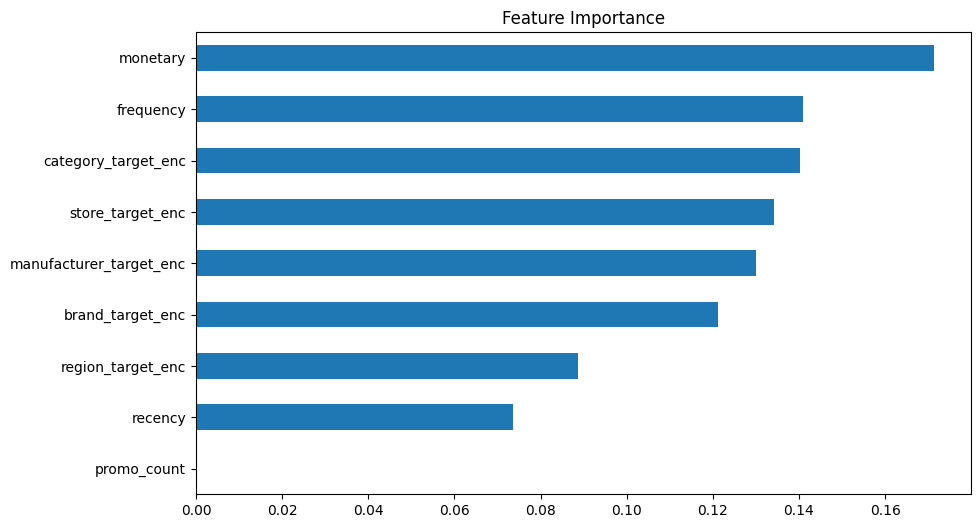

In [ ]:
# ## Build Model (Optimized Random Forest)

print("Training Optimized Random Forest...")

model = RandomForestClassifier(
    n_estimators=1000,          # Increase the number of trees
    max_depth=12,               #Controlling depth to prevent overfitting
    min_samples_leaf=10,        # Prevent leaf nodes from being too small
    max_features='sqrt',
    class_weight='balanced',    # Key: Handling imbalanced samples
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

# Output Results
print('Test Accuracy: {:.4f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.4f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

# (Optional) View feature importance
import matplotlib.pyplot as plt
importances = pd.Series(model.feature_importances_, index=feature_cols)
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [ ]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

Test Accuracy: 0.68
Test AUC: 0.69


# Generate Prediction

In [ ]:
predict_probs = model.predict_proba(predict_final[feature_cols])[:, 1]
predict_out = pd.DataFrame({
    'id': predict_final['id'],
    'active': predict_probs
})
predict_out.head()

,id,active
0,250462324156,0.574250
1,61214568335,0.363404
2,274776763999,0.550852
3,91546215019,0.507267
4,220718580189,0.438448


In [ ]:
predict_out.to_csv('predict.csv', header=True, index=False)
predict_out.head()

,id,active
0,250462324156,0.574250
1,61214568335,0.363404
2,274776763999,0.550852
3,91546215019,0.507267
4,220718580189,0.438448


In [ ]:
# This will download your prediction files
from google.colab import files
files.download('predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>